In [1]:
import os
import numpy as np
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from mllib.model import KerasSurrogate
from tensorflow import keras

In [2]:
class AdjustedRSquaredSeparated(tf.keras.losses.Loss):
    '''
    Calculates the adjusted R^2 value for each predicted quantity separately.

    For more details, see:
    https://www.analyticsvidhya.com/blog/2020/07/difference-between-r-squared-and-adjusted-r-squared/
    '''
    def __init__(self, batch_size, number_of_input):
        '''
        Parameters
        ==========
        batch_size: int
            Number of samples in a batch,
            i. e. number of rows of a batch of the X matrix.
        number_of_input: int
            Number of independent variables (=columns) in the problem,
            i. e. number of columns of the X matrix.
        '''
        super().__init__(name='adjusted_r2')
        self._n = batch_size
        self._n_in = number_of_input

    def call(self, y_true, y_pred):
        r2 = RSquaredSeparated().call(y_true, y_pred)

        adjusted_r2 = 1. - (1. - r2) * (self._n - 1.) / (self._n - self._n_in - 1.)

        return adjusted_r2

    @classmethod
    def from_config(cls, config):
        return AdjustedRSquaredSeparated(config['n'], config['n_in'])

    def get_config(self):
        return {
            'n': self._n,
            'n_in': self._n_in,
        }

In [3]:
class RSquaredSeparated(tf.keras.losses.Loss):
    '''
    Calculates the R^2 value for each predicted quantity separately.

    For more details, see:
    https://www.analyticsvidhya.com/blog/2020/07/difference-between-r-squared-and-adjusted-r-squared/
    '''
    def __init__(self):
        super().__init__(name='r2')

    def call(self, y_true, y_pred):
        mean_true = tf.math.reduce_mean(y_true, axis=0)

        total_sum_of_squares = tf.math.reduce_sum(tf.math.squared_difference(y_true, mean_true),
                                                  axis=0)
        
        residual_sum_of_squares = tf.math.reduce_sum(tf.math.squared_difference(y_true, y_pred),
                                                     axis=0)
        r2 = 1. - residual_sum_of_squares / total_sum_of_squares

        return r2

In [4]:
class AdjustedRSquared(tf.keras.losses.Loss):
    '''
    For more details, see:
    https://www.analyticsvidhya.com/blog/2020/07/difference-between-r-squared-and-adjusted-r-squared/
    '''
    def __init__(self, batch_size, number_of_input):
        '''
        Parameters
        ==========
        batch_size: int
            Number of samples in a batch,
            i. e. number of rows of a batch of the X matrix.
        number_of_input: int
            Number of independent variables (=columns) in the problem,
            i. e. number of columns of the X matrix.
        '''
        super().__init__(name='adjusted_r2')
        self._n = batch_size
        self._n_in = number_of_input

    def call(self, y_true, y_pred):
        r2 = RSquared().call(y_true, y_pred)

        adjusted_r2 = 1. - (1. - r2) * (self._n - 1.) / (self._n - self._n_in - 1.)
        adjusted_r2 = tf.math.reduce_mean(adjusted_r2)

        return adjusted_r2

    @classmethod
    def from_config(cls, config):
        return AdjustedRSquared(config['n'], config['n_in'])

    def get_config(self):
        return {
            'n': self._n,
            'n_in': self._n_in,
        }

In [5]:
#wMAPE

def wmape(actual, pred):
    wMAPE = np.sum(np.abs(actual-pred))/np.sum(np.abs(actual))*100
    return wMAPE

In [6]:
seed = 1234
tf.random.set_seed(seed)
np.random.seed(seed)

# Include test data and Models

In [7]:
test_datafile_fw = '/data/project/general/aerosolretriev/aerosol_data/dataset_12_2022/preprocessed_new/data_all_test_fw1.h5'
test_datafile_iv = '/data/project/general/aerosolretriev/aerosol_data/dataset_12_2022/preprocessed_new/data_all_test_iv1.h5'



In [8]:
model_name_fw = 'forward_model/surrogate_model'
model_name_iv = 'forward_model/surrogate_model'

In [9]:
model_dir_fw = '/data/project/general/aerosolretriev/aerosol_results_december_2022/results_Romana/results_12_12_2022/forward_models_fw1_small/models'
model_dir_iv = '/data/project/general/aerosolretriev/aerosol_results_december_2022/results_Romana/results_12_12_2022/forward_models_iv1_small/models'


In [10]:
# Resulting plots will be stored in the fw model directory
plot_dir = model_dir_fw +'/plots/model_1'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
plot_dir

'/data/project/general/aerosolretriev/aerosol_results_december_2022/results_Romana/results_12_12_2022/forward_models_fw1_small/models/plots/model_1'

# Load the model and the data

In [11]:
custom_objects = {
    'AdjustedRSquared': AdjustedRSquared,
}

kwargs = {
    'custom_objects': custom_objects,
    'compile': False,
}

surr_fw = KerasSurrogate.load(model_dir_fw, model_name_fw, model_kwargs=kwargs)
surr_iv = KerasSurrogate.load(model_dir_iv, model_name_iv, model_kwargs=kwargs)


In [12]:
dvar_test = pd.read_hdf(test_datafile_iv,key = 'dvar')
qoi_test = pd.read_hdf(test_datafile_iv,key = 'qoi')

# I just include the test_datafile_iv, because it should be the same as test_datafile_fw, just dvar and qoi are switched
# In the test datafile dvar are preprocessed already with:
# log(dvar['Vtot'],dvar['RmedianV'],dvar['GSD']-1, dvar['n']-1.33,dvar['k'])
# qoi are preprocessed with log(qoi[F11])

dvar_test_preprocessed = dvar_test.copy()
qoi_test_preprocessed = qoi_test.copy()


In [13]:
#dvar_test1 = pd.read_hdf(test_datafile_fw,key = 'dvar')
#qoi_test1 = pd.read_hdf(test_datafile_fw,key = 'qoi')


# Predict aerosol properties from phase functions

In [14]:
dvar_pred = surr_fw.predict(qoi_test_preprocessed)
dvar_pred = pd.DataFrame(data=dvar_pred, columns=dvar_test.columns)

In [15]:
dvar_pred = np.exp(dvar_pred)
dvar_pred['GSD']=dvar_pred['GSD']+1
dvar_pred['n']= dvar_pred['n']+1.33

dvar_test = np.exp(dvar_test)
dvar_test['GSD']=dvar_test['GSD']+1
dvar_test['n']=dvar_test['n']+1.33

## 1.calculate metrics

In [16]:
fw_error_df = pd.DataFrame(columns = dvar_test.columns)
fw_error_df


Empty DataFrame
Columns: [Vtot, RmedianV, GSD, n, k]
Index: []

In [17]:
# R2 value
metric = AdjustedRSquaredSeparated(dvar_test.shape[0], dvar_test.shape[1])

r2_adj_fw = metric.call(dvar_test.values, dvar_pred.values).numpy()
r2_adj_fw = pd.Series(data=r2_adj_fw, index=dvar_test.columns)
r2_adj_fw = np.round(r2_adj_fw, decimals=2)
r2_adj_fw = pd.DataFrame(r2_adj_fw).T
r2_adj_fw

Vtot  RmedianV   GSD     n     k
0  0.99      0.99  0.99  0.99  0.99

In [18]:
fw_error_df.loc['r2']= [r2_adj_fw['Vtot'].values[0], r2_adj_fw['RmedianV'].values[0],r2_adj_fw['GSD'].values[0],r2_adj_fw['n'].values[0],r2_adj_fw['k'].values[0]]
fw_error_df


Vtot  RmedianV   GSD     n     k
r2  0.99      0.99  0.99  0.99  0.99

In [19]:
# absolute error
abs_error_fw = np.abs(dvar_test-dvar_pred)
abs_error_fw = pd.DataFrame(abs_error_fw, columns=dvar_test.columns).abs()
abs_error_fw.reset_index(drop=True, inplace=True)
abs_error_fw

Vtot   RmedianV       GSD         n         k
0        0.077523  16.537939  0.018282  0.015873  0.013091
1        0.454514  76.285417  0.022312  0.028818  0.042128
2        1.180407   2.294899  0.003111  0.029174  0.207143
3        0.344095   2.852193  0.000479  0.002376  0.094142
4       33.797139   0.853392  0.001470  0.032416  0.027710
...           ...        ...       ...       ...       ...
19464  263.968430   2.375678  0.034597  0.004150  0.003890
19465    0.225088   4.032078  0.001987  0.014129  0.053990
19466    0.084880   2.287355  0.021889  0.019608  0.112288
19467  102.592220  44.378227  0.020722  0.130676  0.038055
19468    1.601974   2.923984  0.000250  0.004187  0.011650

[19469 rows x 5 columns]

In [20]:
abs_error_table_fw = np.round(abs_error_fw.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
abs_error_table_fw

Vtot  RmedianV   GSD     n     k
50%    2.19     13.11  0.02  0.02  0.03
75%   20.72     62.09  0.04  0.04  0.06
90%   90.96    192.75  0.07  0.07  0.09
95%  167.97    346.57  0.10  0.09  0.12
99%  391.08    665.60  0.16  0.17  0.19

In [21]:
fw_error_df.loc['abs error 90%'] = abs_error_table_fw.loc['90%']

fw_error_df.loc['abs error 95%'] = abs_error_table_fw.loc['95%']


In [22]:
rel_error_fw = np.abs(dvar_test - dvar_pred) / dvar_test * 100.
rel_error_fw = pd.DataFrame(rel_error_fw, columns=dvar_test.columns).abs()
rel_error_fw.reset_index(drop=True, inplace=True)
rel_error_fw

Vtot  RmedianV       GSD         n          k
0      1.565156  3.698937  1.083474  0.605182   1.735805
1      4.612701  2.583222  0.846646  1.380185   2.356965
2      4.261396  0.901418  0.297974  1.001258  18.810675
3      0.702069  0.549083  0.021931  0.100519   4.579624
4      7.656333  0.849390  0.066637  1.124143   1.397100
...         ...       ...       ...       ...        ...
19464  9.093301  0.970384  1.688672  0.284462   0.829966
19465  5.933960  1.973140  0.164689  0.904544   4.990579
19466  0.944086  0.433147  1.122702  0.729064   5.991924
19467  4.334155  5.688847  0.810799  4.655671   7.072429
19468  1.898036  1.733937  0.009694  0.163326   1.055144

[19469 rows x 5 columns]

In [23]:
rel_error_table_fw = np.round(rel_error_fw.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
rel_error_table_fw

Vtot  RmedianV   GSD     n      k
50%   3.98      2.52  1.05  1.02   3.43
75%   6.72      4.64  1.94  1.84   5.69
90%   9.82      7.63  3.31  2.93   9.22
95%  12.03     10.53  4.74  3.89  13.80
99%  17.86     16.57  8.66  6.87  42.59

In [24]:
fw_error_df.loc['rel error 90%'] = rel_error_table_fw.loc['90%']

fw_error_df.loc['rel error 95%'] = rel_error_table_fw.loc['95%']
                                            

In [25]:
wMAPE_fw = wmape(dvar_test, dvar_pred)
wMAPE_fw = pd.DataFrame(wMAPE_fw).T
wMAPE_fw=np.round(wMAPE_fw, decimals =2)
wMAPE_fw

Vtot  RmedianV   GSD     n     k
0  5.38      5.47  1.57  1.46  3.82

In [26]:
fw_error_df.loc['wmape'] = [wMAPE_fw['Vtot'].values[0],wMAPE_fw['RmedianV'].values[0],wMAPE_fw['GSD'].values[0],wMAPE_fw['n'].values[0],wMAPE_fw['k'].values[0]]
fw_error_df

Vtot  RmedianV   GSD     n      k
r2               0.99      0.99  0.99  0.99   0.99
abs error 90%   90.96    192.75  0.07  0.07   0.09
abs error 95%  167.97    346.57  0.10  0.09   0.12
rel error 90%    9.82      7.63  3.31  2.93   9.22
rel error 95%   12.03     10.53  4.74  3.89  13.80
wmape            5.38      5.47  1.57  1.46   3.82

In [27]:
fw_error_df.to_csv(f'{plot_dir}/fw_error_df.csv')

## 2. plots

In [28]:
def lognormal(D_array, D_median, GSD, Ntot):  # dn/dD
    n = (Ntot/(np.sqrt(2*np.pi)*(np.log(GSD)))/D_array) * np.exp(-(np.log(D_array)-np.log(D_median))**2/(2*(np.log(GSD)**2)))   # nm-1 * cm-3
    return n

In [29]:
dvar_test['DmedianV']=dvar_test['RmedianV']*2*1e-3 #[um]
dvar_test['DmedianN']=(np.exp(np.log(dvar_test['DmedianV']) - (3*np.log(dvar_test['GSD'])**2))) *1e3   #[nm]
dvar_test['Ntot'] = 6 / np.pi * dvar_test['Vtot']*1e9 / (np.exp((3*np.log(dvar_test['DmedianN'])) + (4.5*np.log(dvar_test['GSD'])**2))) # [cm^-3]
 

In [30]:
dvar_pred['DmedianV']=dvar_pred['RmedianV']*2*1e-3 #[um]
dvar_pred['DmedianN']=(np.exp(np.log(dvar_pred['DmedianV']) - (3*np.log(dvar_pred['GSD'])**2))) *1e3   #[nm]
dvar_pred['Ntot'] = 6 / np.pi * dvar_pred['Vtot']*1e9 / (np.exp((3*np.log(dvar_pred['DmedianN'])) + (4.5*np.log(dvar_pred['GSD'])**2))) # [cm^-3]


In [31]:
D_array = np.logspace(1, 4.5, 200)  # [nm]
presentation_plot_index = [100,200,300,400,500]

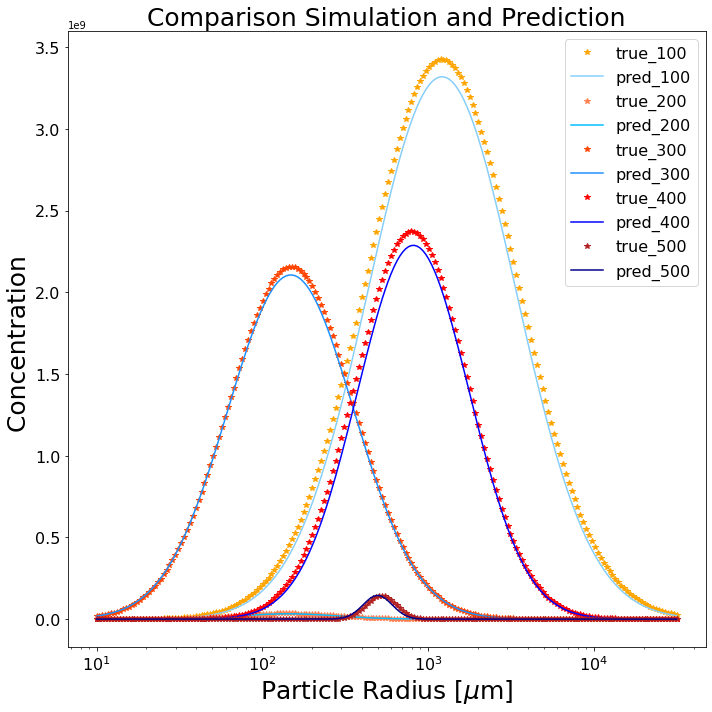

In [32]:
fig, ax = plt.subplots(figsize = (10,10))

colors_blue = ['lightskyblue','deepskyblue','dodgerblue','blue','darkblue']
colors_red = ['orange','coral','orangered','red','firebrick','darkred']

j = 0
for i  in presentation_plot_index:
    
    pdf1 = lognormal(D_array, dvar_test['DmedianN'].loc[i], dvar_test['GSD'].loc[i], dvar_test['Ntot'].loc[i])
    pdf2 = lognormal(D_array, dvar_pred['DmedianN'].loc[i], dvar_pred['GSD'].loc[i], dvar_pred['Ntot'].loc[i])
    
    ax.plot(D_array, pdf1*4/3.*np.pi*D_array**3., '*', color = colors_red[j], label = 'true_'+str(i))
    
    ax.plot(D_array, pdf2*4/3.*np.pi*D_array**3., color = colors_blue[j], label = 'pred_'+str(i))
    


    ax.legend(fontsize = 16)   
    j = j+1
ax.set_xlabel('Particle Radius [$\mu$m]',fontsize = 25)
ax.set_ylabel('Concentration ',fontsize = 25)
ax.tick_params(labelsize = 16)    
ax.set_title( 'Comparison Simulation and Prediction',fontsize = 25)
fig.align_labels()

plt.xscale('log')
#plt.yscale('log')
fig.tight_layout() 
fig.savefig(f'{plot_dir}/size_distribution_true_pred.jpg')

## 3. plot the biggest error 

In [33]:
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [34]:
testGSD1 = rel_error_fw['GSD'].values
testR = rel_error_fw['RmedianV'].values
testn = rel_error_fw['n'].values
testk = rel_error_fw['k'].values
testVtot = rel_error_fw['Vtot'].values
testGSD2 = np.log(dvar_test['RmedianV'].values)
testGSD3 = np.log(dvar_test['GSD'].values)


In [35]:
grid_x, grid_y = np.mgrid[100:5001:1, 1.01:3.1:0.01]

grid_x = np.log(grid_x)
grid_y = np.log(grid_y)
grid_GSD = griddata((testGSD2,testGSD3), testGSD1, (grid_x, grid_y), method='nearest')
grid_R = griddata((testGSD2,testGSD3), testR, (grid_x, grid_y), method='nearest')
grid_Vtot = griddata((testGSD2,testGSD3), testVtot, (grid_x, grid_y), method='nearest')
grid_n = griddata((testGSD2,testGSD3), testn, (grid_x, grid_y), method='nearest')
grid_k = griddata((testGSD2,testGSD3), testk, (grid_x, grid_y), method='nearest')


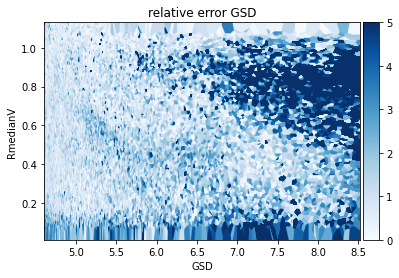

In [36]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(grid_GSD.T, extent=(np.log(100),np.log(5000),np.log(1.01),np.log(3.1)),vmin=0, vmax=5,aspect = 'auto',cmap = 'Blues')

ax.set_xlabel('GSD')
ax.set_ylabel('RmedianV')
ax.set_title('relative error GSD')
fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()
fig.savefig(f'{plot_dir}/rel_errGSD_GSD_R.jpg')

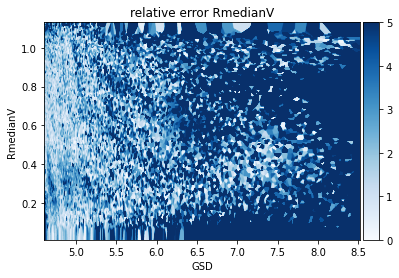

In [37]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(grid_R.T, extent=(np.log(100),np.log(5000),np.log(1.01),np.log(3.1)),vmin=0, vmax=5,aspect = 'auto',cmap = 'Blues')
ax.set_xlabel('GSD')
ax.set_ylabel('RmedianV')
ax.set_title('relative error RmedianV')

fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()
fig.savefig(f'{plot_dir}/rel_errR_GSD_R.jpg')

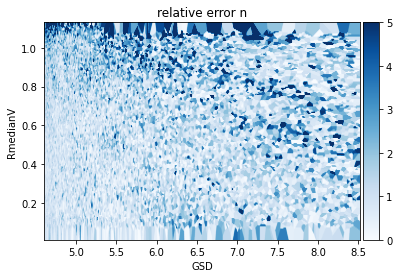

In [38]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(grid_n.T, extent=(np.log(100),np.log(5000),np.log(1.01),np.log(3.1)),vmin=0, vmax=5,aspect = 'auto',cmap = 'Blues')

ax.set_xlabel('GSD')
ax.set_ylabel('RmedianV')
ax.set_title('relative error n')

fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()
fig.savefig(f'{plot_dir}/rel_errn_GSD_R.jpg')

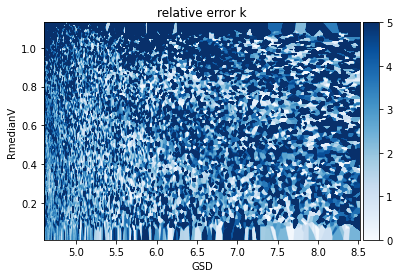

In [39]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(grid_k.T, extent=(np.log(100),np.log(5000),np.log(1.01),np.log(3.1)),vmin=0, vmax=5,aspect = 'auto',cmap = 'Blues')
ax.set_xlabel('GSD')
ax.set_ylabel('RmedianV')
ax.set_title('relative error k')

fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()
fig.savefig(f'{plot_dir}/rel_errk_GSD_R.jpg')

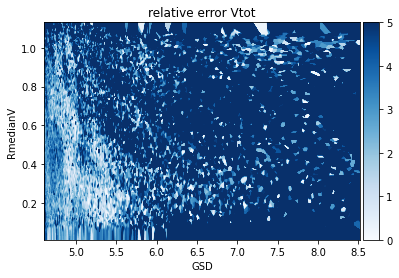

In [40]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(grid_Vtot.T, extent=(np.log(100),np.log(5000),np.log(1.01),np.log(3.1)),vmin=0, vmax=5,aspect = 'auto',cmap = 'Blues')

ax.set_xlabel('GSD')
ax.set_ylabel('RmedianV')
ax.set_title('relative error Vtot')

fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()
fig.savefig(f'{plot_dir}/rel_errVtot_GSD_R.jpg')

# Predict phase functions from aerosol properties

In [41]:
qoi_pred = surr_iv.predict(dvar_test_preprocessed)
qoi_pred = pd.DataFrame(data=qoi_pred, columns=qoi_test.columns)

In [42]:
F11_columns = [x for x in qoi_test.columns if 'F11' in x]
PPF_columns = [x for x in qoi_test.columns if 'PPF' in x]

In [43]:
qoi_test[F11_columns] = np.exp(qoi_test[F11_columns])
qoi_pred[F11_columns] = np.exp(qoi_pred[F11_columns])


In [44]:
## 1. calculate metrics

In [45]:
metric = RSquaredSeparated()
r2_adj_iv = metric.call(qoi_test.values, qoi_pred.values).numpy()
r2_adj_iv = pd.Series(data=r2_adj_iv, index=qoi_test.columns)
r2_adj_iv = np.round(r2_adj_iv, decimals=2)
r2_adj_iv = pd.DataFrame(r2_adj_iv).T
print('Forward model: ','R2_min = ', min(r2_adj_iv.min()),';  R2_max = ', max(r2_adj_iv.max()))
r2_adj_iv

Forward model:  R2_min =  0.68 ;  R2_max =  1.0


F11_10  F11_11  F11_12  F11_13  F11_14  F11_15  F11_16  F11_17  F11_18  \
0    0.99     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0   

   F11_19  ...  PPF_161  PPF_162  PPF_163  PPF_164  PPF_165  PPF_166  PPF_167  \
0     1.0  ...     0.82     0.81     0.79     0.78     0.78     0.76     0.76   

   PPF_168  PPF_169  PPF_170  
0     0.75     0.72     0.68  

[1 rows x 304 columns]

In [46]:
iv_error_df = pd.DataFrame(columns = ['F11','PPF'])
iv_error_df.loc['r2']= [np.mean(r2_adj_iv[F11_columns].mean()),np.mean(r2_adj_iv[PPF_columns].mean())]
iv_error_df

F11       PPF
r2  0.999079  0.960987

In [47]:
r2_adj_iv.values

array([[0.99, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 0.99, 0.99, 0.99, 0.99,
        0.99, 0.99, 0.99, 0.99, 0.99, 

In [48]:
abs_error_iv = np.abs(qoi_pred - qoi_test)
abs_error_iv

F11_10      F11_11      F11_12      F11_13     F11_14     F11_15  \
0        0.329536    0.404104    0.342765    0.279126   0.237489   0.149022   
1        0.008507    0.077995    0.150604    0.177941   0.174186   0.157516   
2        1.731796    3.234374    1.560274    0.665682   2.186260   0.036803   
3       10.549657    8.474556    7.049505    6.521713   6.151729   5.273753   
4        8.528493    9.532372   16.970334   20.885146  20.538325  18.274901   
...           ...         ...         ...         ...        ...        ...   
19464   66.454219   82.447596   99.961293   78.584301  40.427600  41.113340   
19465    0.055849    0.045969    0.155502    0.302777   0.432679   0.517926   
19466    1.423739    1.235132    1.106138    1.063145   0.976138   0.815700   
19467  347.666569  268.404375  202.630203  135.489292  96.151230  43.747870   
19468    1.448866    2.130863    4.033340    5.273642   5.557397   6.229846   

          F11_16     F11_17     F11_18     F11_19  ...   PPF_161   PPF_162  \
0       0.126916   0.133256   0.125682   0.113455  ...  0.008278  0.007338   
1       0.138095   0.113435   0.102546   0.083297  ...  0.002040  0.002777   
2       0.763208   0.231067   1.007192   1.986870  ...  0.046609  0.047268   
3       4.449680   4.046650   3.285790   3.067836  ...  0.000549  0.000727   
4      16.774150  15.653647  15.375732  13.038560  ...  0.000030  0.000682   
...          ...        ...        ...        ...  ...       ...       ...   
19464  23.045320   6.417560   1.481137   9.783483  ...  0.002081  0.002125   
19465   0.585933   0.529941   0.490906   0.444439  ...  0.004436  0.003386   
19466   0.639125   0.554723   0.432600   0.382646  ...  0.000667  0.000309   
19467  15.771275   7.907107   2.790499   4.324173  ...  0.004258  0.003980   
19468   6.664922   6.327053   6.324143   5.980694  ...  0.001297  0.001879   

        PPF_163   PPF_164   PPF_165   PPF_166   PPF_167   PPF_168   PPF_169  \
0      0.007207  0.006739  0.005654  0.004885  0.004198  0.003227  0.002304   
1      0.002627  0.003051  0.003086  0.003610  0.002879  0.002351  0.002084   
2      0.046614  0.045425  0.043509  0.040281  0.035499  0.033023  0.030013   
3      0.001267  0.002114  0.002349  0.001967  0.002159  0.002188  0.002210   
4      0.000597  0.001175  0.000815  0.001397  0.000571  0.000353  0.000546   
...         ...       ...       ...       ...       ...       ...       ...   
19464  0.001524  0.001097  0.000054  0.000088  0.001085  0.002167  0.002288   
19465  0.004280  0.004222  0.004182  0.004525  0.005002  0.003951  0.003761   
19466  0.000164  0.001161  0.001442  0.001343  0.001854  0.001866  0.002066   
19467  0.004417  0.004289  0.003868  0.003668  0.003159  0.002597  0.002130   
19468  0.002135  0.002752  0.003011  0.003099  0.003128  0.002874  0.002822   

        PPF_170  
0      0.001716  
1      0.002461  
2      0.026289  
3      0.001622  
4      0.000604  
...         ...  
19464  0.002145  
19465  0.003070  
19466  0.001882  
19467  0.001358  
19468  0.002762  

[19469 rows x 304 columns]

In [49]:
abs_error_table_iv =  np.round(abs_error_iv.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
abs_error_table_iv

F11_10  F11_11  F11_12  F11_13  F11_14  F11_15  F11_16  F11_17  F11_18  \
50%    2.84    2.18    1.70    1.48    1.25    1.10    0.96    0.83    0.75   
75%   26.12   20.13   15.93   13.96   12.29   10.96    9.63    8.22    7.26   
90%  124.34  100.76   82.85   72.30   64.06   59.60   52.79   46.02   41.00   
95%  252.03  207.88  171.79  152.49  136.68  124.67  114.80  104.43   94.45   
99%  779.91  614.83  512.14  457.83  400.45  385.62  352.79  321.53  287.55   

     F11_19  ...  PPF_161  PPF_162  PPF_163  PPF_164  PPF_165  PPF_166  \
50%    0.68  ...     0.00     0.00     0.00     0.00     0.00     0.00   
75%    6.49  ...     0.00     0.00     0.00     0.00     0.00     0.00   
90%   37.05  ...     0.01     0.01     0.01     0.01     0.01     0.01   
95%   86.07  ...     0.01     0.01     0.01     0.01     0.01     0.01   
99%  272.22  ...     0.05     0.05     0.05     0.04     0.04     0.04   

     PPF_167  PPF_168  PPF_169  PPF_170  
50%     0.00     0.00     0.00     0.00  
75%     0.00     0.00     0.00     0.00  
90%     0.01     0.01     0.01     0.01  
95%     0.01     0.01     0.01     0.01  
99%     0.04     0.04     0.03     0.03  

[5 rows x 304 columns]

In [50]:
iv_error_df.loc['abs error 90%']=[abs_error_table_iv[F11_columns].loc['90%'].max(), abs_error_table_iv[PPF_columns].loc['90%'].max()]
iv_error_df.loc['abs error 95%']=[abs_error_table_iv[F11_columns].loc['95%'].max(), abs_error_table_iv[PPF_columns].loc['95%'].max()]


In [51]:
rel_error_iv = abs_error_iv / qoi_test * 100.
rel_error_iv = pd.DataFrame(rel_error_iv, columns=qoi_test.columns).abs()
rel_error_iv

F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0      1.651555  2.210112  2.051191  1.831528  1.711456  1.180876  1.106789   
1      0.105868  1.205329  2.849281  4.069397  4.760992  5.093236  5.233446   
2      1.686530  3.222034  1.593396  0.698415  2.361634  0.041020  0.879641   
3      6.015791  5.367373  4.948951  5.064115  5.272078  4.977301  4.614654   
4      0.886846  1.010937  1.837238  2.310060  2.322630  2.114370  1.986674   
...         ...       ...       ...       ...       ...       ...       ...   
19464  0.846784  1.110823  1.425929  1.188141  0.648408  0.699978  0.416717   
19465  0.465246  0.389546  1.342654  2.667961  3.897093  4.775851  5.540180   
19466  4.262163  4.117347  4.103446  4.384772  4.470408  4.142160  3.592982   
19467  5.461468  4.795565  4.095705  3.082950  2.451790  1.244883  0.498869   
19468  0.614670  0.945162  1.870563  2.557103  2.816946  3.300403  3.689433   

         F11_17    F11_18    F11_19  ...     PPF_161     PPF_162     PPF_163  \
0      1.279543  1.329107  1.321375  ...   25.104655   24.105391   25.814532   
1      4.995778  5.207321  4.841928  ...   10.970359   16.315478   16.946497   
2      0.275986  1.249357  2.565111  ...  139.343235  140.643263  140.992674   
3      4.601453  4.087810  4.166866  ...    1.597919    2.292160    4.361312   
4      1.898811  1.911064  1.661163  ...    0.068797    1.734811    1.695868   
...         ...       ...       ...  ...         ...         ...         ...   
19464  0.123298  0.030244  0.212356  ...    3.370733    3.806622    3.037172   
19465  5.146088  4.903402  4.573331  ...    7.589136    6.375347    8.931208   
19466  3.446521  2.965179  2.888117  ...    2.205385    1.100939    0.631407   
19467  0.277015  0.107907  0.183977  ...   12.623675   12.946586   15.866439   
19468  3.658627  3.818881  3.770165  ...    2.606936    4.187383    5.306810   

          PPF_164     PPF_165     PPF_166     PPF_167     PPF_168     PPF_169  \
0       26.521236   24.654579   23.836298   23.184546   20.432504   16.980557   
1       21.725751   24.418410   31.980958   28.817491   26.886605   27.576235   
2      142.406485  143.997461  143.296178  138.226906  143.424489  148.359371   
3        7.994489    9.839163    9.215729   11.438179   13.272688   15.578793   
4        3.761378    2.959787    5.812741    2.752855    1.990143    3.659511   
...           ...         ...         ...         ...         ...         ...   
19464    2.450422    0.137227    0.252848    3.598408    8.379554   10.465451   
19465    9.835775   10.973485   13.497667   17.152028   15.770590   17.728300   
19466    4.894376    6.693808    6.932182   10.753548   12.328430   15.784886   
19467   17.138370   17.331528   18.602585   18.327583   17.453461   16.821417   
19468    7.686948    9.524617   11.206576   13.064768   14.035964   16.343317   

          PPF_170  
0       14.990004  
1       38.285932  
2      151.216361  
3       13.521087  
4        4.886436  
...           ...  
19464   11.808104  
19465   17.391261  
19466   16.924433  
19467   12.825644  
19468   19.286584  

[19469 rows x 304 columns]

In [52]:
rel_error_table_iv = np.round(rel_error_iv.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
rel_error_table_iv

F11_10  F11_11  F11_12  F11_13  F11_14  F11_15  F11_16  F11_17  F11_18  \
50%    2.83    2.50    2.26    2.20    2.08    2.06    2.02    1.99    1.95   
75%    5.15    4.41    4.03    3.98    3.86    3.82    3.77    3.66    3.58   
90%    8.75    7.42    6.76    6.64    6.45    6.46    6.27    6.07    5.91   
95%   12.25   10.62    9.76    9.45    9.33    9.26    9.01    8.83    8.56   
99%   26.70   24.05   22.49   22.62   23.53   22.73   21.78   20.07   19.12   

     F11_19  ...  PPF_161  PPF_162  PPF_163  PPF_164  PPF_165  PPF_166  \
50%    1.94  ...     7.41     8.08     9.10    10.92    11.67    13.00   
75%    3.55  ...    14.96    16.55    18.50    21.49    23.20    25.99   
90%    5.85  ...    27.18    30.18    32.69    37.22    40.59    46.06   
95%    8.40  ...    44.84    48.63    51.57    56.41    59.94    64.90   
99%   18.87  ...   183.40   180.57   166.53   179.74   181.26   183.00   

     PPF_167  PPF_168  PPF_169  PPF_170  
50%    13.73    13.63    15.01    17.14  
75%    27.78    28.58    31.41    35.22  
90%    49.67    52.43    57.88    65.61  
95%    69.93    74.69    82.42    93.48  
99%   180.97   188.30   193.30   215.63  

[5 rows x 304 columns]

In [53]:
iv_error_df.loc['rel error 90%']=[rel_error_table_iv[F11_columns].loc['90%'].max(), rel_error_table_iv[PPF_columns].loc['90%'].max()]
iv_error_df.loc['rel error 95%']=[rel_error_table_iv[F11_columns].loc['95%'].max(), rel_error_table_iv[PPF_columns].loc['95%'].max()]


In [54]:

abs_error_table_F11 = abs_error_table_iv[F11_columns]
print('Absolute error F11')
print(abs_error_table_F11.max(axis = 1))
abs_error_table_PPF = abs_error_table_iv[PPF_columns]
print('Absolute error PPF')
print(abs_error_table_PPF.max(axis = 1))
rel_error_table_F11 = rel_error_table_iv[F11_columns]
print('Relative error F11')
print(rel_error_table_F11.max(axis = 1))
rel_error_table_PPF = rel_error_table_iv[PPF_columns]
print('Relative error PPF')
print(rel_error_table_PPF.max(axis = 1))


Absolute error F11
50%      2.84
75%     26.12
90%    124.34
95%    252.03
99%    779.91
dtype: float64
Absolute error PPF
50%    0.01
75%    0.01
90%    0.02
95%    0.03
99%    0.08
dtype: float64
Relative error F11
50%     2.83
75%     5.15
90%     8.75
95%    12.25
99%    27.28
dtype: float64
Relative error PPF
50%     17.14
75%     35.22
90%     65.61
95%     93.48
99%    486.59
dtype: float64


In [55]:
wMAPE_qoi = wmape(qoi_test, qoi_pred)
wMAPE_qoi = pd.DataFrame(wMAPE_qoi).T
np.round(wMAPE_qoi, decimals =2)

F11_10  F11_11  F11_12  F11_13  F11_14  F11_15  F11_16  F11_17  F11_18  \
0    3.79     3.4    3.12     3.0    2.93    2.92    2.86    2.78     2.7   

   F11_19  ...  PPF_161  PPF_162  PPF_163  PPF_164  PPF_165  PPF_166  PPF_167  \
0    2.69  ...    12.88    13.93    15.13    16.92    17.99    19.62    20.85   

   PPF_168  PPF_169  PPF_170  
0    21.75    23.71    26.28  

[1 rows x 304 columns]

In [56]:
iv_error_df.loc['wmape']=[wMAPE_qoi[F11_columns].mean().mean(),wMAPE_qoi[PPF_columns].mean().mean()]
iv_error_df

F11        PPF
r2               0.999079   0.960987
abs error 90%  124.340000   0.020000
abs error 95%  252.030000   0.030000
rel error 90%    8.750000  65.610000
rel error 95%   12.250000  93.480000
wmape            3.050692   4.423245

In [57]:
iv_error_df.to_csv(f'{plot_dir}/iv_error_df.csv')

## 2. plots

In [58]:
theta = []
for i in range(10,86):
    theta.append(i)
for i in range(95,171):
    theta.append(i)

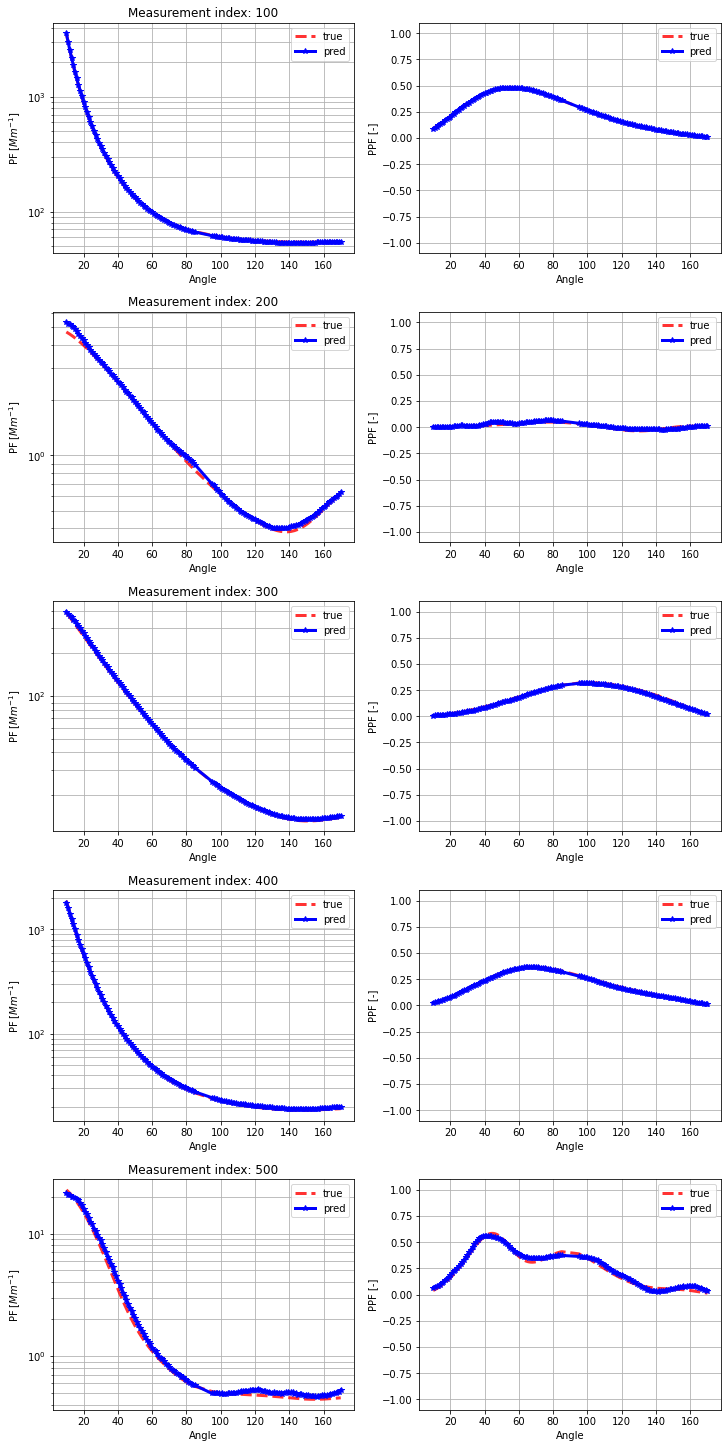

In [59]:
presentation_plot_index = [100,200,300,400,500]
fig, axs = plt.subplots(ncols=2, nrows=5, figsize=(10, 20), constrained_layout=True)
nr = 0
for index in presentation_plot_index:
    axs[nr,0].set_title('Measurement index: '+str(index))

    pms_hdf_plot, = axs[nr,0].plot(theta, qoi_test[F11_columns].loc[index], ls='--', markersize = 5, lw='3', c='r', alpha=0.8, label='true')
    pms_hdf_plot, = axs[nr,1].plot(theta, qoi_test[PPF_columns].loc[index], ls='--', lw='3', c='r', alpha=0.8, label='true')

    meas_hdf_plot, = axs[nr,0].plot(theta, qoi_pred[F11_columns].loc[index],'*',ls = '-',lw ='3', c= 'b', label = 'pred')
    meas_hdf_plot, = axs[nr,1].plot(theta, qoi_pred[PPF_columns].loc[index],'*',ls = '-',lw ='3', c= 'b', label = 'pred')
    

    axs[nr,0].set_ylabel('PF [$Mm^{-1}$]')
    axs[nr,1].set_ylabel('PPF [-]')
    axs[nr,1].set_ylim(-1.1, 1.1)
    axs[nr,0].set_yscale('log')
    for ax in axs.reshape(-1):
        ax.set_xlabel('Angle')
        ax.legend(handles=[pms_hdf_plot,meas_hdf_plot])
        ax.grid(which='both')
    nr = nr+1
fig.savefig(f'{plot_dir}/phase_functions_true_pred.jpg')